In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_cycling/"
res_DIR = "../data/results_cycling/"
# %matplotlib widget

In [2]:
spm = pybamm.lithium_ion.SPMe(
    {
        # "SEI": "ec reaction limited",
        # # "loss of active material": ("stress-driven","none"),
        # "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [3]:
parameter_values = get_parameter_values()

In [4]:
cell = 2
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
print(cell_no)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": 1.2676e-07,#2.7081e-07, #4.1759e-07,#2.7081e-07, #2.5112e-07,
        "Negative electrode LAM constant proportional term [s-1]": 1.2713e-06,#3.7576e-06, #3.2693e-06,#3.7576e-06, #2.4741e-06,
        "Positive electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        "EC diffusivity [m2.s-1]": 8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        # "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity,
        # "Positive electrode diffusivity [m2.s-1]" NMC_diffusivity,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
        "Upper voltage cut-off [V]": 4.2,
    },
    check_already_exists=False,
)


02


In [5]:
dis_set = " until 3V"
c_rate_d = 'C/20'
c_rate_c = 'C/20'
experiment_rev_exp = pybamm.Experiment(
    [
        "Discharge at "+c_rate_d+dis_set,
        "Rest for 60 min",
        "Charge at "+c_rate_c+" until 4.2V", 
        # "Hold at 4.2V until C/50"
    ],
)

In [6]:
def rev_exp(cyc_no,eSOH,eSOH_data):
    # dfo = dfo_0[dfo_0['N']==N[cyc_no]]
    model = spm
    Vmin = 3.0
    Vmax = 4.2
    esoh_model = pybamm.lithium_ion.ElectrodeSOH()
    esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
    param = model.param
    Cn = eSOH["C_n"][cyc_no]
    # print(Cn)
    Cp = eSOH["C_p"][cyc_no]
    c_n_max = parameter_values.evaluate(param.n.prim.c_max)
    c_p_max = parameter_values.evaluate(param.p.prim.c_max)
    n_Li_init = eSOH["n_Li"][cyc_no]
    eps_n_data = parameter_values.evaluate(Cn*3600/(param.n.L * param.n.prim.c_max * param.F* param.A_cc))
    eps_p_data = parameter_values.evaluate(Cp*3600/(param.p.L * param.p.prim.c_max * param.F* param.A_cc))

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
        solver=pybamm.AlgebraicSolver(),
    )

    parameter_values.update(
        {
            "Initial concentration in negative electrode [mol.m-3]": esoh_sol[
       "x_100"
            ].data[0]
            * c_n_max,
            "Initial concentration in positive electrode [mol.m-3]": esoh_sol[
                "y_100"
            ].data[0]
            * c_p_max,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+25,
            "Ambient temperature [K]": 273.15+25,
            
        }
    )

    sim_exp = pybamm.Simulation(
        model, experiment=experiment_rev_exp, parameter_values=parameter_values,
        solver=pybamm.CasadiSolver("safe")
    )
    sol_exp = sim_exp.solve()
    t_t = sol_exp["Time [min]"].entries
    I_t = sol_exp["Current [A]"].entries
    Q_t = -sol_exp['Discharge capacity [A.h]'].entries
    Vt_t = sol_exp["Terminal voltage [V]"].entries
    idx = np.where(np.diff(np.sign(I_t)))[0]
    I = I_t[idx[-1]:]
    t = t_t[idx[-1]:]-t_t[idx[-1]]
    Q = Q_t[idx[-1]:]-Q_t[idx[-1]]
    Vt = Vt_t[idx[-1]:]
    # Q_filt = ((Q/max(Q))>0.15)
    # int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
    # rmse_V = pybamm.rmse(Vt*Q_filt,int_V(Q)*Q_filt)
    # V_err = Vt*Q_filt-int_V(Q)*Q_filt
    # V_max_loc = np.argmax(abs(V_err))
    # V_err_Q = Q[V_max_loc]
    # V_err_max = V_err[V_max_loc]
    if max(Q)<max(eSOH_data['Q']):
        int_V = interpolate.CubicSpline(eSOH_data['Q'],eSOH_data['V'],extrapolate=True)
        rmse_V = pybamm.rmse(Vt,int_V(Q))
        V_err = Vt-int_V(Q)
        max_V = abs(V_err[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = Q[V_max_loc]
        V_err_max = V_err[V_max_loc]
        Q_err = Q
    else:
        int_V = interpolate.CubicSpline(Q,Vt,extrapolate=True)
        rmse_V = pybamm.rmse(eSOH_data['V'],int_V(eSOH_data['Q']))
        V_err = int_V(eSOH_data['Q'])-eSOH_data['V']
        max_V = abs(V_err.iloc[-2])
        V_max_loc = np.argmax(abs(V_err))
        V_err_Q = eSOH_data['Q'].iloc[V_max_loc]
        V_err_max = V_err.iloc[V_max_loc]
        Q_err = eSOH_data['Q']
    return Q,Vt,rmse_V,max_V

5


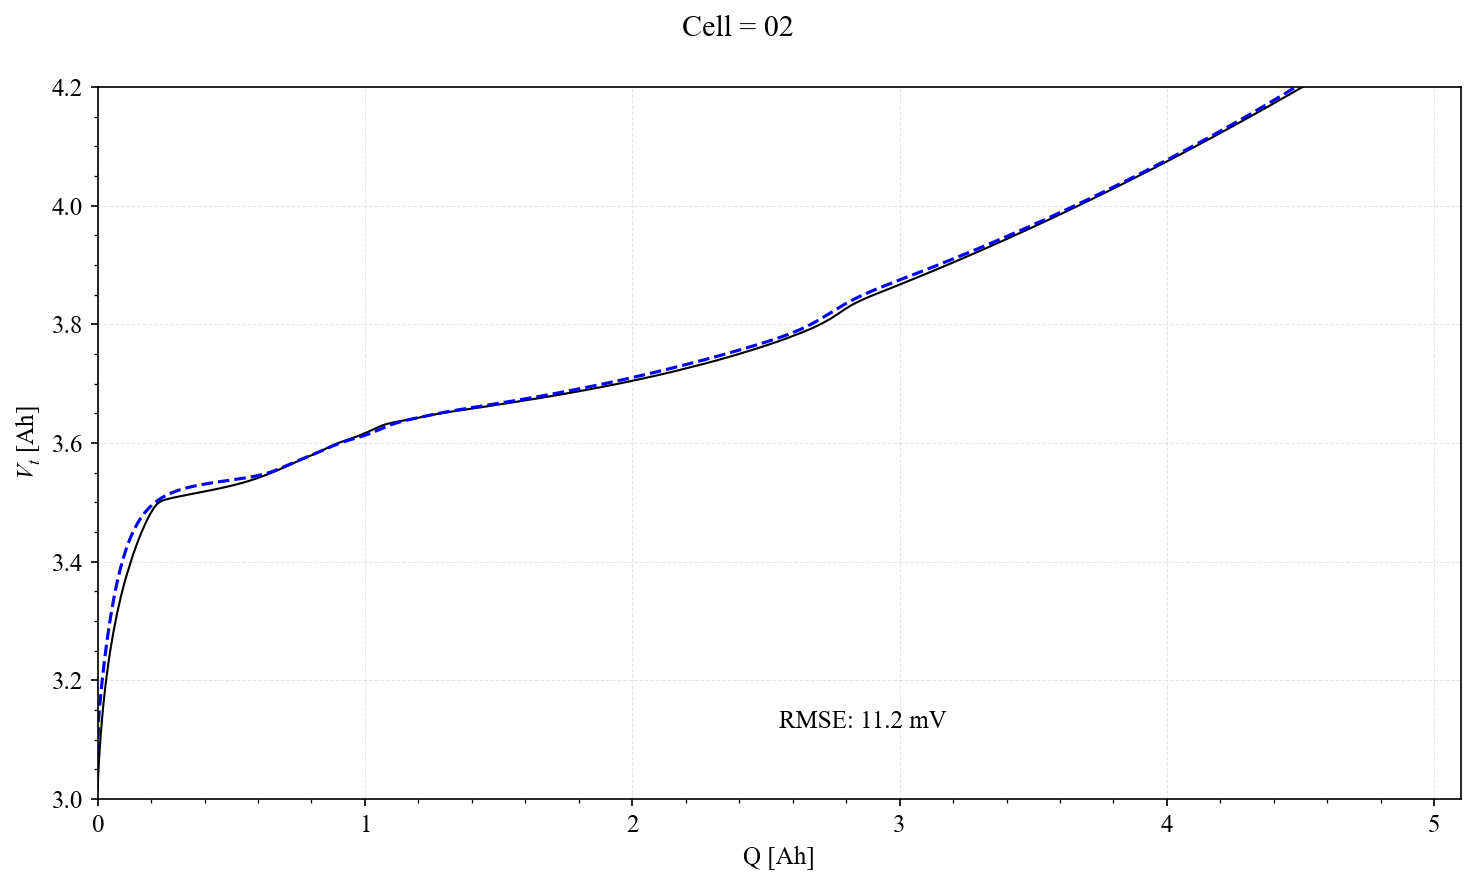

In [7]:
fig, axes = plt.subplots(1,figsize=(10,6))
for cyc_no in [5]:
# for cyc_no in range(0,int((len(N)+1)/2),len(N)-1):
    # cyc_no=0
    print(cyc_no)
    dfo = dfo_0[dfo_0['N']==N_0[cyc_no+1]]
    Q,Vt,rmse_V,max_V = rev_exp(cyc_no,dfe,dfo)
    ax2 = axes
    ax2.plot(dfo['Q'],dfo['V'],'k',linewidth=1)
    ax2.plot(Q,Vt,'b--',linewidth=1.5)
    ax2.set_ylim([3,4.2])
    ax2.set_xlim([0,5.1])
    ax2.set_xlabel('Q [Ah]')
    ax2.text(0.5,0.1,f'RMSE: {rmse_V*1e3:0.1f} mV',transform=ax2.transAxes)
    ax2.set_ylabel('$V_t$ [Ah]')
fig.suptitle('Cell = '+cell_no)
fig.tight_layout()
plt.savefig(fig_DIR +'ocv_sim'+cell_no+'_fresh.png')